In [2]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error as rmse

## Loading data

In [3]:
DATA_PATH = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'

# Adjust these column names as needed.
date_col = 'time'
target_col = 'KarupBro'
# List of meteorological features from DMI – update if needed.
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]


# Read the CSV
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional: Set the date column as index (if needed)
df.set_index(date_col, inplace=True)

df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_speed_daily,wind_gust_max_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro
time,,,,,,,,,,,,,,,,
2024-12-27,4.0,6.0,5.250000,2.016421,6.6,7.4,6.941667,97.250000,223.583333,1.966667,6.0,0.0,0.0,131.0,12.0,NaN
2024-12-28,3.3,5.1,4.116667,1.946083,6.1,6.9,6.445833,97.666667,217.708333,3.050000,7.7,0.0,0.0,188.0,25.0,NaN
2024-12-29,4.5,8.4,7.133333,1.524006,6.1,7.4,6.812500,91.958333,231.291667,6.154167,15.4,0.1,0.0,210.0,26.0,NaN
2024-12-30,7.7,8.9,8.179167,2.204877,7.1,7.9,7.466667,91.041667,236.416667,8.741667,16.7,2.9,0.0,87.0,0.0,NaN
2024-12-31,7.9,8.6,8.300000,1.909754,7.5,7.8,7.600000,85.000000,261.000000,9.400000,16.4,0.0,0.0,0.0,0.0,NaN


In [4]:
# Check for missing values
df.isnull().sum()

temp_min_daily               0
temp_max_daily               0
temp_mean_daily              0
temp_grass_mean_daily        0
temp_soil_min_daily          0
temp_soil_max_daily          0
temp_soil_mean_daily         0
humidity_daily               0
wind_direction_daily         0
wind_speed_daily             0
wind_gust_max_daily          0
precip_total_daily           0
precip_duration_daily        0
radiation_global_daily       0
sunshine_duration_daily      0
KarupBro                   366
dtype: int64

In [5]:
# Forward fill and check again
df = df.iloc[:-366]
df.isnull().sum()

temp_min_daily             0
temp_max_daily             0
temp_mean_daily            0
temp_grass_mean_daily      0
temp_soil_min_daily        0
temp_soil_max_daily        0
temp_soil_mean_daily       0
humidity_daily             0
wind_direction_daily       0
wind_speed_daily           0
wind_gust_max_daily        0
precip_total_daily         0
precip_duration_daily      0
radiation_global_daily     0
sunshine_duration_daily    0
KarupBro                   0
dtype: int64

## Filtering data to simple model

In [6]:
df_simple = df[["temp_mean_daily", "precip_total_daily", "KarupBro"]]
df_simple.head()

,temp_mean_daily,precip_total_daily,KarupBro
time,,,
2002-01-01,1.250000,2.2,1829.75
2002-01-02,-0.837500,0.0,7279.46
2002-01-03,-5.166667,0.0,5261.85
2002-01-04,-6.025000,0.0,2951.97
2002-01-05,-3.466667,0.1,1868.53


<Axes: xlabel='time'>

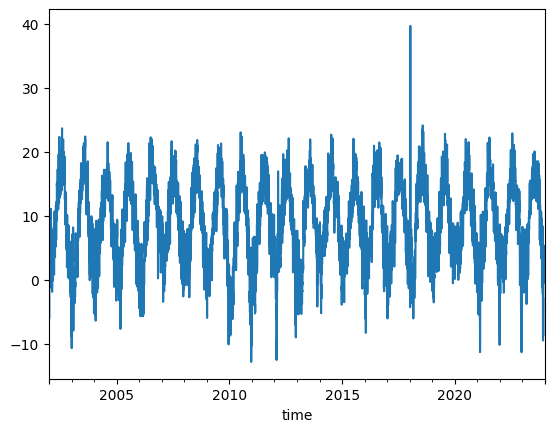

In [7]:
temp = df['temp_mean_daily']
temp.plot()

In [8]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

<Axes: xlabel='time'>

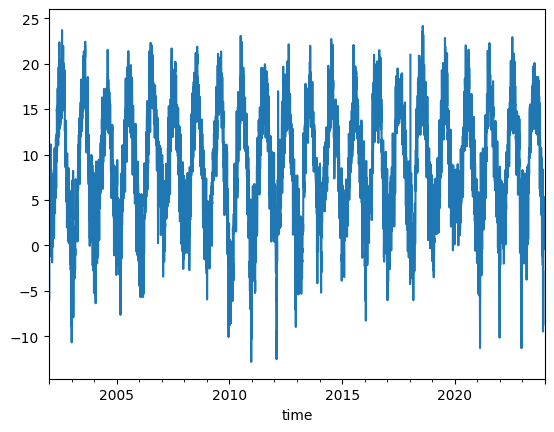

In [9]:
temp.plot()

<Axes: xlabel='time'>

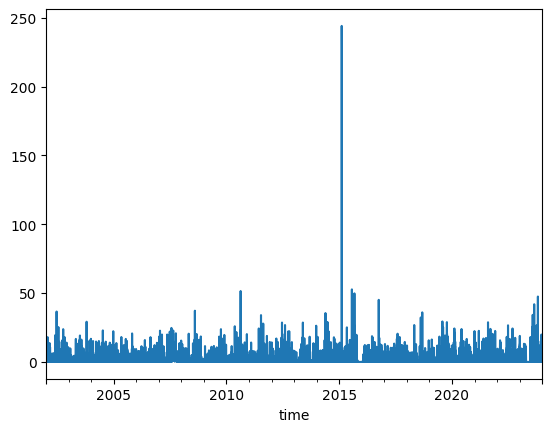

In [10]:
rain = df['precip_total_daily']
rain.plot()

In [11]:
import numpy as np

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

<Axes: xlabel='time'>

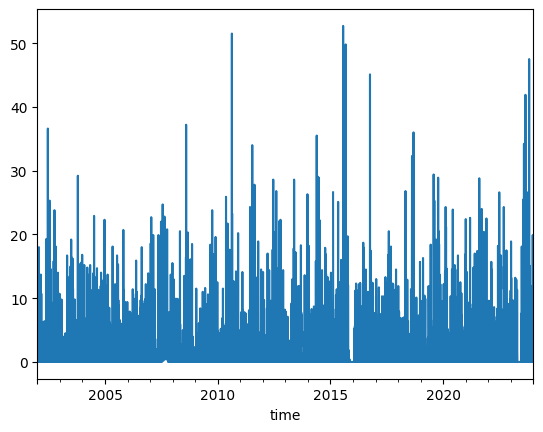

In [12]:
rain.plot()

<Axes: xlabel='time'>

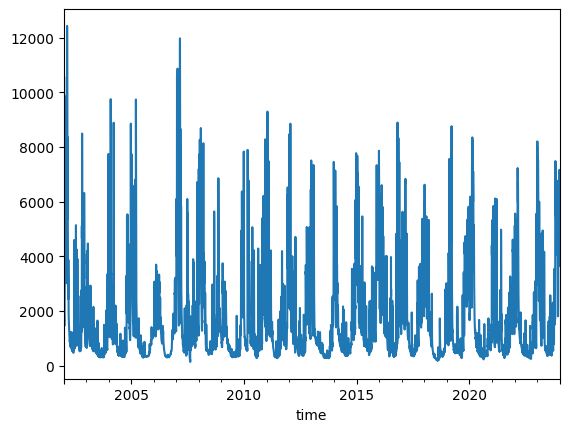

In [13]:
inflow = df['KarupBro']
inflow.plot()

## Multi-variable

In [14]:
inflow_df = pd.DataFrame({'Inflow':inflow})
inflow_df['Seconds'] = inflow_df.index.map(pd.Timestamp.timestamp)
inflow_df

,Inflow,Seconds
time,,
2002-01-01,1829.75,1.009843e+09
2002-01-02,7279.46,1.009930e+09
2002-01-03,5261.85,1.010016e+09
2002-01-04,2951.97,1.010102e+09
2002-01-05,1868.53,1.010189e+09
...,...,...
2023-12-27,5197.40,1.703635e+09
2023-12-28,6368.46,1.703722e+09
2023-12-29,7162.01,1.703808e+09


In [15]:
day = 24*60*60
year = (365.2425)*day

inflow_df['Rain'] = df['precip_total_daily']
inflow_df['Temp'] = df['temp_mean_daily']
inflow_df['Year sin'] = np.sin(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df['Year cos'] = np.cos(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df = inflow_df.drop('Seconds', axis=1)
inflow_df

,Inflow,Rain,Temp,Year sin,Year cos
time,,,,,
2002-01-01,1829.75,2.2,1.250000,0.004129,0.999991
2002-01-02,7279.46,0.0,-0.837500,0.021330,0.999772
2002-01-03,5261.85,0.0,-5.166667,0.038525,0.999258
2002-01-04,2951.97,0.0,-6.025000,0.055708,0.998447
2002-01-05,1868.53,0.1,-3.466667,0.072875,0.997341
...,...,...,...,...,...
2023-12-27,5197.40,0.0,0.471667,-0.087536,0.996161
2023-12-28,6368.46,0.0,0.255556,-0.070387,0.997520
2023-12-29,7162.01,0.0,0.039444,-0.053217,0.998583


In [16]:
import numpy as np

HORIZON = 5

def df_to_X_y_multi_step_exo(df, window_size=5, horizon=HORIZON):
    """
    Prepares data for direct multi-step forecasting (k-step ahead) by:
      - Using the past 'window_size' days of data as historical input.
      - Including the exogenous features (Rain, Temp, cos_year, sin_year) 
        for the *next* 'horizon' days.
      - Predicting 'horizon' days of inflow in one shot.

    Assumes:
      - df columns = [Inflow, Rain, Temp, cos_year, sin_year]
      - 'window_size' = number of past days (e.g., 5)
      - 'horizon' = forecast length (e.g., 3)

    Returns:
      X : shape (num_samples, window_size, 5 + 4*horizon)
          The last row of each sample contains the exogenous data for each future day.
      y : shape (num_samples, horizon)
          The inflow values for the next 'horizon' days.
    """
    df_as_np = df.to_numpy()  # shape (total_days, 5)
    X, y = [], []
    n = len(df_as_np)
    
    # We need enough data for 'window_size' historical days + 'horizon' future days
    for i in range(n - window_size - horizon + 1):
        # 1) Extract the 5-day historical window: shape (window_size, 5)
        hist_window = df_as_np[i : i + window_size, :5]
        
        # 2) Extract the exogenous features for the next 'horizon' days (cols 1..4)
        #    shape (horizon, 4)
        exo_future = df_as_np[i + window_size : i + window_size + horizon, 1:5]
        
        # 3) Build an expanded window with shape (window_size, 5 + 4*horizon)
        #    We copy the original 5 features into columns 0..4 for every row,
        #    and in the *last row only*, we append the horizon exo data.
        sample = np.zeros((window_size, 5 + 4 * horizon))
        
        # Fill columns 0..4 with the historical data for each of the 'window_size' rows
        sample[:, :5] = hist_window
        
        # For the last row, place each day's exo in the extra columns
        # day 0 exo goes to columns [5..9), day 1 exo goes to [9..13), etc.
        for day_idx in range(horizon):
            start_col = 5 + 4 * day_idx
            end_col   = start_col + 4
            sample[-1, start_col:end_col] = exo_future[day_idx]
        
        # 4) The label is the inflow for the next 'horizon' days: shape (horizon,)
        future_inflow = df_as_np[i + window_size : i + window_size + horizon, 0]
        
        X.append(sample)
        y.append(future_inflow)
    
    return np.array(X), np.array(y)

In [17]:
# X2, y2 = df_to_X_y2(inflow_df)
X, y = df_to_X_y_multi_step_exo(inflow_df)

X.shape, y.shape

((8026, 5, 25), (8026, 5))

In [18]:
X2_train, y2_train = X[:6000], y[:6000]
X2_val, y2_val = X[6000:7000], y[6000:7000]
X2_test, y2_test = X[7000:], y[7000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((6000, 5, 25), (6000, 5), (1000, 5, 25), (1000, 5), (1026, 5, 25), (1026, 5))

### Preprocessing

In [19]:
# Compute the training statistics from the first channel (inflow) in X2_train
inflow_training_mean = np.mean(X2_train[:, :, 0])
inflow_training_std = np.std(X2_train[:, :, 0])

rain_training_mean = np.mean(X2_train[:, :, 1])
rain_training_std = np.std(X2_train[:, :, 1])

temp_training_mean = np.mean(X2_train[:, :, 2])
temp_training_std = np.std(X2_train[:, :, 2])

# Define the preprocessing functions for features and output
def preprocess(X):
    # Standardize the first three channels (features)
    X[:, :, 0] = (X[:, :, 0] - inflow_training_mean) / inflow_training_std 
    X[:, :, 1] = (X[:, :, 1] - rain_training_mean) / rain_training_std
    X[:, :, 2] = (X[:, :, 2] - temp_training_mean) / temp_training_std 
    return X

def preprocess_output(y):
    # Standardize every element in y
    y[:] = (y[:] - inflow_training_mean) / inflow_training_std
    return y

# Apply preprocessing to all datasets
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)
preprocess_output(y2_train)
preprocess_output(y2_val)
preprocess_output(y2_test)

array([[-0.38355823, -0.44990893, -0.47533252, -0.49399215,  0.94305818],
       [-0.44990893, -0.47533252, -0.49399215,  0.94305818,  2.3903177 ],
       [-0.47533252, -0.49399215,  0.94305818,  2.3903177 ,  2.01318602],
       ...,
       [ 2.38340918,  2.40427327,  2.13534093,  2.8406845 ,  3.31864924],
       [ 2.40427327,  2.13534093,  2.8406845 ,  3.31864924,  3.14241273],
       [ 2.13534093,  2.8406845 ,  3.31864924,  3.14241273,  2.82074797]])

In [20]:
X2_test[0] , y2_test[0]

(array([[-0.16178693, -0.47387479, -1.02918874,  0.86394287,  0.50358984,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.20456313, -0.47387479, -1.23306787,  0.87247775,  0.48865384,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.23627486, -0.47387479, -1.06207248,  0.88075444,  0.47357324,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense

model4 = Sequential()
model4.add(InputLayer(input_shape=(5, 5+4*HORIZON)))  # (window_size, 5 + 4*horizon)
model4.add(LSTM(64, activation='relu'))
model4.add(Dense(32, activation='relu'))
# Output 3 values at once (for 3-day forecast)
model4.add(Dense(HORIZON, activation='linear'))

model4.compile(optimizer='adam', loss='mse')
model4.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                23040     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 25285 (98.77 KB)
Trainable params: 25285 (98.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [23]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=100, callbacks=[cp4])

Epoch 1/100
181/188 [===========================>..] - ETA: 0s - loss: 0.7964 - root_mean_squared_error: 0.8924INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 6ms/step - loss: 0.7959 - root_mean_squared_error: 0.8921 - val_loss: 0.6683 - val_root_mean_squared_error: 0.8175
Epoch 2/100
166/188 [=========================>....] - ETA: 0s - loss: 0.5155 - root_mean_squared_error: 0.7180INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.5015 - root_mean_squared_error: 0.7082 - val_loss: 0.3145 - val_root_mean_squared_error: 0.5608
Epoch 3/100
168/188 [=========================>....] - ETA: 0s - loss: 0.3301 - root_mean_squared_error: 0.5745INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.3264 - root_mean_squared_error: 0.5713 - val_loss: 0.2072 - val_root_mean_squared_error: 0.4552
Epoch 4/100
184/188 [============================>.] - ETA: 0s - loss: 0.2647 - root_mean_squared_error: 0.5145INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.2643 - root_mean_squared_error: 0.5141 - val_loss: 0.1515 - val_root_mean_squared_error: 0.3893
Epoch 5/100
179/188 [===========================>..] - ETA: 0s - loss: 0.2301 - root_mean_squared_error: 0.4797INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.2281 - root_mean_squared_error: 0.4776 - val_loss: 0.1259 - val_root_mean_squared_error: 0.3549
Epoch 6/100
181/188 [===========================>..] - ETA: 0s - loss: 0.2037 - root_mean_squared_error: 0.4513INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 6ms/step - loss: 0.2054 - root_mean_squared_error: 0.4532 - val_loss: 0.1142 - val_root_mean_squared_error: 0.3379
Epoch 7/100
166/188 [=========================>....] - ETA: 0s - loss: 0.1921 - root_mean_squared_error: 0.4383INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.1903 - root_mean_squared_error: 0.4362 - val_loss: 0.1141 - val_root_mean_squared_error: 0.3378
Epoch 8/100
187/188 [============================>.] - ETA: 0s - loss: 0.1799 - root_mean_squared_error: 0.4242INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.1799 - root_mean_squared_error: 0.4241 - val_loss: 0.0989 - val_root_mean_squared_error: 0.3145
Epoch 9/100
180/188 [===========================>..] - ETA: 0s - loss: 0.1724 - root_mean_squared_error: 0.4152INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.1714 - root_mean_squared_error: 0.4140 - val_loss: 0.0966 - val_root_mean_squared_error: 0.3109
Epoch 10/100
156/188 [=======================>......] - ETA: 0s - loss: 0.1715 - root_mean_squared_error: 0.4141INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.1647 - root_mean_squared_error: 0.4058 - val_loss: 0.0876 - val_root_mean_squared_error: 0.2959
Epoch 11/100
180/188 [===========================>..] - ETA: 0s - loss: 0.1584 - root_mean_squared_error: 0.3979INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.1579 - root_mean_squared_error: 0.3974 - val_loss: 0.0828 - val_root_mean_squared_error: 0.2878
Epoch 12/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1528 - root_mean_squared_error: 0.3910 - val_loss: 0.0894 - val_root_mean_squared_error: 0.2989
Epoch 13/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1479 - root_mean_squared_error: 0.3846 - val_loss: 0.1000 - val_root_mean_squared_error: 0.3163
Epoch 14/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1440 - root_mean_squared_error: 0.3795 - val_loss: 0.0953 - val_root_mean_squared_error: 0.3087
Epoch 15/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1399 - root_mean_squared_error: 0.3740 - val_loss: 0.0935 - val_root_mean_squared_error: 0.3058
Epoch 16/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1375 - root_mean_squared_error: 0.3708 - val_loss: 0.0900 - val_r

In [24]:
def postprocess(arr):
    # Apply the inverse transformation to all elements in the array
    return (arr * inflow_training_std) + inflow_training_mean

def get_predictions_postprocessed(model, X, y):
    # Get multi-step predictions from the model (shape: (num_samples, horizon))
    predictions = model.predict(X)
    # Postprocess predictions and actuals
    predictions_post = postprocess(predictions)
    y_post = postprocess(y)
    
    # Assume horizon is the number of days predicted (e.g., 3)
    horizon = predictions_post.shape[1]
    
    # Create a dictionary with columns for each forecast day
    data = {}
    for i in range(horizon):
        data[f'Inflow Predictions Day {i+1}'] = predictions_post[:, i]
        data[f'Inflow Actuals Day {i+1}'] = y_post[:, i]
    
    # Create and return a DataFrame with the results
    return pd.DataFrame(data)

# Example usage:
post_processed_df = get_predictions_postprocessed(model4, X2_test, y2_test)
post_processed_df


33/33 [==============================] - 0s 750us/step


,Inflow Predictions Day 1,Inflow Actuals Day 1,Inflow Predictions Day 2,Inflow Actuals Day 2,Inflow Predictions Day 3,Inflow Actuals Day 3,Inflow Predictions Day 4,Inflow Actuals Day 4,Inflow Predictions Day 5,Inflow Actuals Day 5
0,1576.411133,1015.35,1685.171631,905.19,1381.699707,862.98,946.052368,832.00,2501.888184,3217.89
1,1869.235962,905.19,1811.388672,862.98,1003.488525,832.00,3220.741699,3217.89,6657.156250,5620.73
2,1928.427734,862.98,1927.503174,832.00,3220.458740,3217.89,6306.842773,5620.73,6677.777832,4994.59
3,875.661255,832.00,2883.507568,3217.89,6922.092773,5620.73,7194.916992,4994.59,7442.719238,6097.29
4,3853.342285,3217.89,8622.426758,5620.73,8094.353027,4994.59,8171.465820,6097.29,7058.402832,5512.87
...,...,...,...,...,...,...,...,...,...,...
1021,5526.115234,5809.15,4805.899414,5197.78,4627.416016,5609.26,3906.556152,5643.90,3468.747314,5197.40
1022,5002.945801,5197.78,4646.696777,5609.26,3957.206055,5643.90,3176.133301,5197.40,2828.634766,6368.46
1023,4848.052734,5609.26,3988.161621,5643.90,3309.164551,5197.40,2905.374268,6368.46,2689.166992,7162.01
1024,4498.041016,5643.90,3638.003662,5197.40,3127.301758,6368.46,2802.914062,7162.01,2411.677490,6869.41


In [25]:
def compute_rmse_for_each_horizon(df, horizon=HORIZON):
    """
    Compute RMSE for each forecast horizon using the rmse package/function.

    Parameters:
      df      : DataFrame with columns 
                'Inflow Predictions Day 1', 'Inflow Actuals Day 1', 
                'Inflow Predictions Day 2', 'Inflow Actuals Day 2', etc.
      horizon : Number of forecast days (e.g., 3)

    Returns:
      A dictionary with RMSE for each forecast day.
    """
    rmse_dict = {}
    for i in range(1, horizon + 1):
        pred_col = f'Inflow Predictions Day {i}'
        actual_col = f'Inflow Actuals Day {i}'
        rmse_val = rmse(df[pred_col], df[actual_col])
        rmse_dict[f'Day {i}'] = rmse_val
    return rmse_dict

# Example usage:
rmse_values = compute_rmse_for_each_horizon(post_processed_df, horizon=HORIZON)
rmse_values


{'Day 1': 478.44226776757176,
 'Day 2': 684.1636947780243,
 'Day 3': 831.2711576387334,
 'Day 4': 929.1604749699766,
 'Day 5': 937.3549999322792}

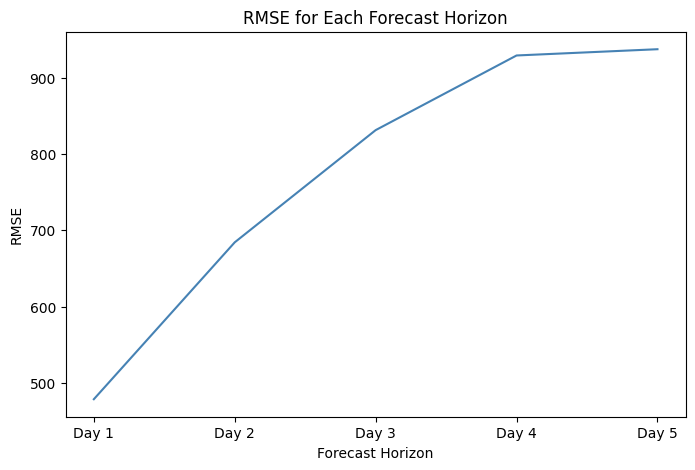

In [26]:
def plot_rmse_for_each_horizon(rmse_dict):
    """
    Plots a bar chart of RMSE for each forecast horizon.
    
    Parameters:
      rmse_dict : Dictionary with keys like 'Day 1', 'Day 2', ... and RMSE values.
    """
    horizons = list(rmse_dict.keys())
    rmse_values = list(rmse_dict.values())
    
    plt.figure(figsize=(8, 5))
    plt.plot(horizons, rmse_values, color='steelblue')
    plt.xlabel("Forecast Horizon")
    plt.ylabel("RMSE")
    plt.title("RMSE for Each Forecast Horizon")
    plt.show()

# Example usage:
rmse_values = compute_rmse_for_each_horizon(post_processed_df, horizon=HORIZON)
plot_rmse_for_each_horizon(rmse_values)

In [27]:
rmse_values.values()

dict_values([478.44226776757176, 684.1636947780243, 831.2711576387334, 929.1604749699766, 937.3549999322792])

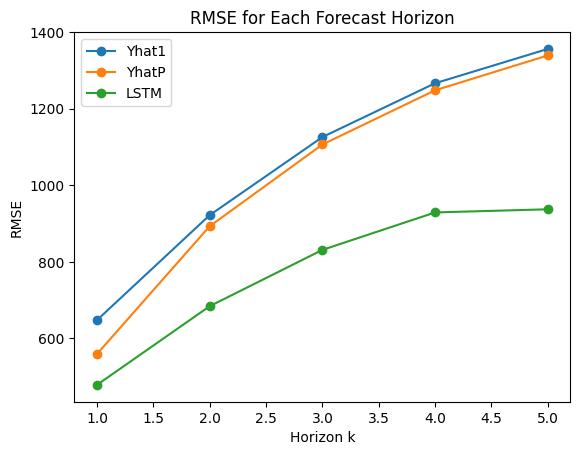

In [28]:
# Hard-coded RMSE values from R
rmse_yhat1 = [647.6976, 922.0222, 1126.1235, 1266.7477, 1356.4172]
rmse_yhatp = [559.0008, 893.0612, 1106.6746, 1248.3544, 1339.4242]

horizons = list(range(1,HORIZON+1))

# Plot each list with a line
plt.plot(horizons, rmse_yhat1, marker='o', label='Yhat1')
plt.plot(horizons, rmse_yhatp, marker='o', label='YhatP')
plt.plot(horizons, rmse_values.values(), marker='o', label='LSTM')

plt.xlabel("Horizon k")
plt.ylabel("RMSE")
plt.title("RMSE for Each Forecast Horizon")
plt.legend()
plt.show()